# Calcul numérique du modèle MFG

Ce notebook contient le calcul des solutions numériques au modèle de trafic comme MFG proposé par Chevalier, Le Ny et Malhamé. Le schéma de discrétisation est celui proposé dans le même article, dans le but de réproduire les résultats montrés dans la dernière partie de l'article.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Calcul des itérations en arrière de HJB
Deux fonctions sont créées. _rhoTilde_ est le calcul de 
$$\tilde{\rho}_j^i = \sum_{k \geq i} \rho_j^k w((k-i)\Delta x) \Delta x$$
pour un instant j donné, qui constitue une approximation $$\int_{i\Delta x}^{\infty} \rho_{j\Delta t}(y-i\Delta x) w(y)dy$$ 

In [2]:
def rhoTilde(rho,n,w,dx):
    
    # Calcule rhoTilde à un instant donné.
    
    rho_tilde = [[sum([rho[j][k]*w((k-i)*dx)*dx for k in range(i,m)])for i in range(m)] for j in range(n)]
    return rho_tilde

La fonction _backwardsHJB_ calcule une itération du schéma en arrière pour l'équation HJB. On prend $V_T(x) = 0$ sur $[0,L]$ et on calcule $V$ et $v$ en arrière  

In [3]:
def backwardsHJB(T,L,n,m,rho,alpha,w):
    # Cette fonction calcule une itération du schéma HJB.
    dt = T/n
    dx = L/m
    V = [[0 for i in range(m)] for j in range(n)]
    v = [[0 for i in range(m)] for j in range(n)]
    rho_tilde = rhoTilde(rho,n,w,dx)
    liste_temps = reversed(list(range(n-1)))
    for j in liste_temps:
        for i in range(m-1):
            v[j][i] = 1/alpha * (1 - rho_tilde[j][i] + (V[j][i+1] - V[j][i])/dx)
            V[j][i] = V[j+1][i] + dt/2 * alpha * (v[j][i])**2
    return V,v


## Calcul de l'itération en volumes finis pour la loi de conservation
On utilise le schéma Lax-Wendroff explicite pour calculer $\rho$ à partir du $v$ obtenu par HJB.

In [4]:
def discretisationLW(rho,v,dt,dx,n,m):

    # Calcule une itération du calcul de rho utilisant le schéma Lax-Wendroff

    rhov = [[rho[j][i]*v[j][i] for i in range(m)] for j in range(n)]
    for j in range(n-1):
        for i in range(1,m-1):
            rho[j+1][i] = rho[j][i] - dt/(2*dx) * (rhov[j][i+1] - rhov[j][i-1]) + 1/2 * (dt/dx)**2 * ((v[j][i] + v[j][i+1])/2 * (rhov[j][i+1]-rhov[j][i+1]) - (v[j][i-1] + v[j][i])/2 * (rhov[j][i] - rhov[j][i-1]))
    return rho

## Application aux conditions proposées dans l'article

Text(0.5, 1.0, "Condition d'entrée")

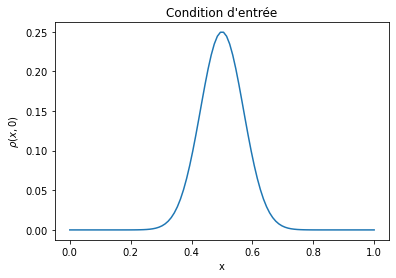

In [5]:
L = 1
T = 1
n = 100
m = 100
x  = np.linspace(0,L,m)
rho_0 = 0.25*np.exp(-((x-0.5)/0.1)**2)
alpha = 1/0.07

plt.figure()
plt.plot(x,rho_0)
plt.xlabel('x')
plt.ylabel(r'$\rho(x,0)$')
plt.title("Condition d'entrée")

### Fonction d'anticipation impulsionnelle

In [14]:
# Discrétisation d'une delta de Dirac : w(x) = 1/dx si x = 0, 0 sinon
w = lambda y: m/L * (y == 0)

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
v = [[0 for i in range(m)] for j in range(n)]
res = 10
liste_eps2 =[]
it = 0
for h in range(20):
    V,v1 = backwardsHJB(T,L,n,m,rho,alpha,w)
    res = T*L/(m*n) * np.sqrt(sum([sum([(v[j][i]-v1[j][i])**2 for i in range(n)]) for j in range(m)]))
    v = v1
    rho1 = discretisationLW(rho,v,T/n,L/m,n,m)
    eps2 = T*L/(m*n) * np.sqrt(sum([sum([(rho1[j][i]-rho[j][i])**2 for i in range(n)]) for j in range(m)]))
    liste_eps2.append(eps2)
    rho = rho1
    it += 1

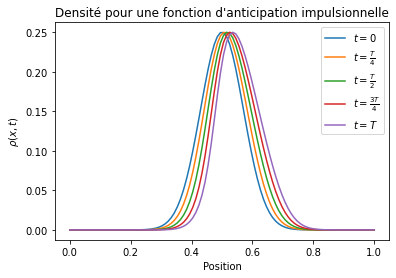

In [15]:
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.title("Densité pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$\rho(x,t)$")
plt.legend()

Text(0, 0.5, '$\\dfrac{v(x,T)}{v_{max}(T)}$')

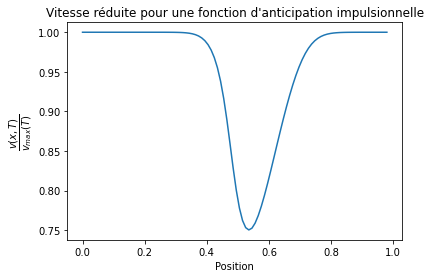

In [8]:
plt.figure()
plt.plot(x[:m-2],v[n-2][:m-2]/max(v[n-2][:m-2]))
plt.title("Vitesse réduite pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$\dfrac{v(x,T)}{v_{max}(T)}$")

### Fonction d'anticipation gaussienne

In [16]:
EX0 = sum([x[i] * rho_0[i]*L/m for i in range(len(x))])
VarX0 = sum([(x[i]-EX0)**2 * rho_0[i] * L/m for i in range(len(x))])
lda = 0.1 * np.sqrt(VarX0)
w = lambda y: 1/lda * np.exp(-y/lda)

In [17]:
rho = [[rho_0[j] for j in range(m)] for i in range(n)]
v = [[0 for i in range(m)] for j in range(n)]
res = 10
liste_eps2 =[]
it = 0
while res > 1e-15:
    V,v1 = backwardsHJB(T,L,n,m,rho,alpha,w)
    res = T*L/(m*n) * np.sqrt(sum([sum([(v[j][i]-v1[j][i])**2 for i in range(n)]) for j in range(m)]))
    v = v1
    rho1 = discretisationLW(rho,v,T/n,L/m,n,m)
    eps2 = T*L/(m*n) * np.sqrt(sum([sum([(rho1[j][i]-rho[j][i])**2 for i in range(n)]) for j in range(m)]))
    liste_eps2.append(eps2)
    rho = rho1
    it += 1

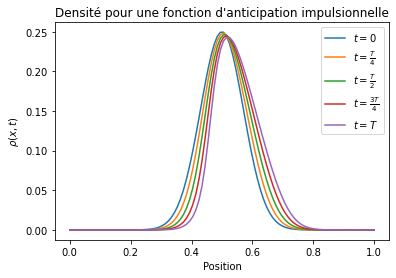

In [18]:
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.title("Densité pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$\rho(x,t)$")
plt.legend()

Text(0, 0.5, '$\\dfrac{v(x,T)}{v_{max}(T)}$')

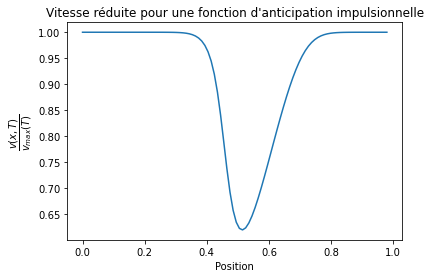

In [19]:
plt.figure()
plt.plot(x[:m-2],v[n-2][:m-2]/max(v[n-2][:m-2]))
plt.title("Vitesse réduite pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$\dfrac{v(x,T)}{v_{max}(T)}$")